In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
def convert_data_to_tensors(data, word_vectors):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            if word in word_vectors:
                embedding.append(word_vectors[word])
            else:
                embedding.append([0] * len(word_vectors['hello']))  # Use a zero vector for unknown words
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(word_vectors['hello'])] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [5]:

x_train = convert_data_to_tensors(train_data, word_vectors)
x_val = convert_data_to_tensors(val_data, word_vectors)
x_test = convert_data_to_tensors(test_data, word_vectors)

/tmp/ipykernel_31916/3668873182.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [6]:
x_train.size()

torch.Size([906, 83, 300])

In [7]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [8]:
y_train.size()

torch.Size([906, 83])

In [9]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [10]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = LSTMTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_31916/2600715320.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_31916/2600715320.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_31916/2600715320.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_31916/2600715320.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/150, Train Loss: 1.2288573384284973, Val Loss: 1.0089361667633057, Val F1: 0.31532441302701336, Train F1: 0.24647101428565157


  1%|█▉                                                                                                                                                | 2/150 [00:01<01:45,  1.40it/s]

Epoch 2/150, Train Loss: 0.7222186662256718, Val Loss: 0.5092613101005554, Val F1: 0.31532441302701336, Train F1: 0.31471959699562335


  2%|██▉                                                                                                                                               | 3/150 [00:02<01:43,  1.43it/s]

Epoch 3/150, Train Loss: 0.5130082294344902, Val Loss: 0.48182249069213867, Val F1: 0.31532441302701336, Train F1: 0.31504082227023245


  3%|███▉                                                                                                                                              | 4/150 [00:02<01:41,  1.44it/s]

Epoch 4/150, Train Loss: 0.4592015817761421, Val Loss: 0.41853153705596924, Val F1: 0.31532441302701336, Train F1: 0.3149550935310621


  3%|████▊                                                                                                                                             | 5/150 [00:03<01:38,  1.47it/s]

Epoch 5/150, Train Loss: 0.4189356192946434, Val Loss: 0.4063746929168701, Val F1: 0.31532441302701336, Train F1: 0.3149905688619384


  4%|█████▊                                                                                                                                            | 6/150 [00:04<01:37,  1.47it/s]

Epoch 6/150, Train Loss: 0.40250246971845627, Val Loss: 0.38197416067123413, Val F1: 0.31532441302701336, Train F1: 0.3148732326042679


  5%|██████▊                                                                                                                                           | 7/150 [00:04<01:36,  1.48it/s]

Epoch 7/150, Train Loss: 0.39236555993556976, Val Loss: 0.36561334133148193, Val F1: 0.31532441302701336, Train F1: 0.31433806518147134


  5%|███████▊                                                                                                                                          | 8/150 [00:05<01:34,  1.50it/s]

Epoch 8/150, Train Loss: 0.4044366888701916, Val Loss: 0.3495136499404907, Val F1: 0.3176088906005162, Train F1: 0.3122100906106668


  6%|████████▊                                                                                                                                         | 9/150 [00:06<01:33,  1.51it/s]

Epoch 9/150, Train Loss: 0.3510483279824257, Val Loss: 0.334279865026474, Val F1: 0.3176088906005162, Train F1: 0.3169130669392362


  7%|█████████▋                                                                                                                                       | 10/150 [00:06<01:32,  1.52it/s]

Epoch 10/150, Train Loss: 0.3408195190131664, Val Loss: 0.3168155550956726, Val F1: 0.31987831333468913, Train F1: 0.3173914012902746


  7%|██████████▋                                                                                                                                      | 11/150 [00:07<01:31,  1.53it/s]

Epoch 11/150, Train Loss: 0.32176371291279793, Val Loss: 0.30222198367118835, Val F1: 0.3454896319577269, Train F1: 0.3260058659917908


  8%|███████████▌                                                                                                                                     | 12/150 [00:08<01:31,  1.50it/s]

Epoch 12/150, Train Loss: 0.32008348777890205, Val Loss: 0.2876054346561432, Val F1: 0.3808614366394687, Train F1: 0.3616048873345305


  9%|████████████▌                                                                                                                                    | 13/150 [00:08<01:33,  1.46it/s]

Epoch 13/150, Train Loss: 0.326068390160799, Val Loss: 0.27473828196525574, Val F1: 0.41189848407779955, Train F1: 0.39958938247351916


  9%|█████████████▌                                                                                                                                   | 14/150 [00:09<01:34,  1.45it/s]

Epoch 14/150, Train Loss: 0.279595447704196, Val Loss: 0.26159632205963135, Val F1: 0.4208911059947131, Train F1: 0.4243588721427495


 10%|██████████████▌                                                                                                                                  | 15/150 [00:10<01:32,  1.46it/s]

Epoch 15/150, Train Loss: 0.2803082540631294, Val Loss: 0.25141575932502747, Val F1: 0.43677576792066497, Train F1: 0.41778779714070563


 11%|███████████████▍                                                                                                                                 | 16/150 [00:10<01:30,  1.48it/s]

Epoch 16/150, Train Loss: 0.2702386751770973, Val Loss: 0.23883523046970367, Val F1: 0.4453953391553737, Train F1: 0.4529595793697813


 11%|████████████████▍                                                                                                                                | 17/150 [00:11<01:29,  1.49it/s]

Epoch 17/150, Train Loss: 0.2520582638680935, Val Loss: 0.22957444190979004, Val F1: 0.5100002283698147, Train F1: 0.5074384091442988


 12%|█████████████████▍                                                                                                                               | 18/150 [00:12<01:28,  1.50it/s]

Epoch 18/150, Train Loss: 0.23876820132136345, Val Loss: 0.21976032853126526, Val F1: 0.6065039945954437, Train F1: 0.5322550504504843


 13%|██████████████████▎                                                                                                                              | 19/150 [00:12<01:27,  1.50it/s]

Epoch 19/150, Train Loss: 0.22369988821446896, Val Loss: 0.20907612144947052, Val F1: 0.6024085164739134, Train F1: 0.5804240002090448


 13%|███████████████████▎                                                                                                                             | 20/150 [00:13<01:26,  1.50it/s]

Epoch 20/150, Train Loss: 0.21246585436165333, Val Loss: 0.19997209310531616, Val F1: 0.6664677643701332, Train F1: 0.5924352793124209


 14%|████████████████████▎                                                                                                                            | 21/150 [00:14<01:26,  1.49it/s]

Epoch 21/150, Train Loss: 0.2139089945703745, Val Loss: 0.19249793887138367, Val F1: 0.6821556080535971, Train F1: 0.6335415570849914


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:14<01:25,  1.49it/s]

Epoch 22/150, Train Loss: 0.1998387947678566, Val Loss: 0.18764695525169373, Val F1: 0.6847247899601494, Train F1: 0.6978706641477204


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:15<01:25,  1.49it/s]

Epoch 23/150, Train Loss: 0.210933368653059, Val Loss: 0.18272057175636292, Val F1: 0.7231316984182196, Train F1: 0.677763383341271


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:16<01:27,  1.44it/s]

Epoch 24/150, Train Loss: 0.19590529054403305, Val Loss: 0.1789775937795639, Val F1: 0.7071701525982544, Train F1: 0.7300458435434083


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:16<01:25,  1.46it/s]

Epoch 25/150, Train Loss: 0.18507741391658783, Val Loss: 0.17375388741493225, Val F1: 0.744277941468741, Train F1: 0.7252650635396701


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:17<01:24,  1.47it/s]

Epoch 26/150, Train Loss: 0.18248130194842815, Val Loss: 0.1729145050048828, Val F1: 0.7141274729079061, Train F1: 0.7541954385383393


 18%|██████████████████████████                                                                                                                       | 27/150 [00:18<01:24,  1.46it/s]

Epoch 27/150, Train Loss: 0.177483431994915, Val Loss: 0.17252816259860992, Val F1: 0.7725531904267106, Train F1: 0.7482151311707327


 19%|███████████████████████████                                                                                                                      | 28/150 [00:18<01:22,  1.48it/s]

Epoch 28/150, Train Loss: 0.1711750514805317, Val Loss: 0.16983717679977417, Val F1: 0.7254103131183797, Train F1: 0.7834684259254799


 19%|████████████████████████████                                                                                                                     | 29/150 [00:19<01:21,  1.48it/s]

Epoch 29/150, Train Loss: 0.1754721663892269, Val Loss: 0.1710967719554901, Val F1: 0.700946180430971, Train F1: 0.7777037232593259


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:20<01:21,  1.48it/s]

Epoch 30/150, Train Loss: 0.1734531857073307, Val Loss: 0.17037081718444824, Val F1: 0.7673030590972602, Train F1: 0.7461718594482166


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:20<01:19,  1.49it/s]

Epoch 31/150, Train Loss: 0.16784329898655415, Val Loss: 0.16492785513401031, Val F1: 0.7204650520688256, Train F1: 0.7549804061201915


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:21<01:19,  1.49it/s]

Epoch 32/150, Train Loss: 0.16123215481638908, Val Loss: 0.15720658004283905, Val F1: 0.7799115377643387, Train F1: 0.7802999558440172


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:22<01:20,  1.46it/s]

Epoch 33/150, Train Loss: 0.1583708431571722, Val Loss: 0.15601880848407745, Val F1: 0.7671167757904319, Train F1: 0.7833063648215525


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:23<01:18,  1.48it/s]

Epoch 34/150, Train Loss: 0.15156343299895525, Val Loss: 0.15507125854492188, Val F1: 0.7684616149735856, Train F1: 0.7936308323279961


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:23<01:16,  1.50it/s]

Epoch 35/150, Train Loss: 0.15478242188692093, Val Loss: 0.15353929996490479, Val F1: 0.7807361202374693, Train F1: 0.7885583586343312


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:24<01:16,  1.49it/s]

Epoch 36/150, Train Loss: 0.15345790050923824, Val Loss: 0.1538863182067871, Val F1: 0.776738528779295, Train F1: 0.7932625662268308


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:24<01:14,  1.51it/s]

Epoch 37/150, Train Loss: 0.15060140192508698, Val Loss: 0.14959032833576202, Val F1: 0.7787242839955546, Train F1: 0.8055983615130856


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:25<01:13,  1.52it/s]

Epoch 38/150, Train Loss: 0.1401235545054078, Val Loss: 0.14889433979988098, Val F1: 0.7801930183815545, Train F1: 0.8189211270681133


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:26<01:12,  1.53it/s]

Epoch 39/150, Train Loss: 0.14599497709423304, Val Loss: 0.1567915678024292, Val F1: 0.753090181249579, Train F1: 0.8119037964736204


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:26<01:11,  1.53it/s]

Epoch 40/150, Train Loss: 0.14440064877271652, Val Loss: 0.1476454883813858, Val F1: 0.7897830869316279, Train F1: 0.8030661001473839


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:27<01:10,  1.54it/s]

Epoch 41/150, Train Loss: 0.13885416369885206, Val Loss: 0.14972619712352753, Val F1: 0.791065889762366, Train F1: 0.8181757909129158


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:28<01:09,  1.54it/s]

Epoch 42/150, Train Loss: 0.1318909488618374, Val Loss: 0.1480642557144165, Val F1: 0.7779375596251313, Train F1: 0.8252915020308094


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:28<01:08,  1.55it/s]

Epoch 43/150, Train Loss: 0.13259252160787582, Val Loss: 0.1496766209602356, Val F1: 0.7855368257385921, Train F1: 0.8166717437355115


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:29<01:07,  1.56it/s]

Epoch 44/150, Train Loss: 0.13578120432794094, Val Loss: 0.1483873426914215, Val F1: 0.7800943852507284, Train F1: 0.8322145317779842


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:30<01:07,  1.56it/s]

Epoch 45/150, Train Loss: 0.13181877322494984, Val Loss: 0.1468188762664795, Val F1: 0.8010907639559522, Train F1: 0.8286767295087426


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:30<01:06,  1.55it/s]

Epoch 46/150, Train Loss: 0.12524713389575481, Val Loss: 0.1453232318162918, Val F1: 0.803044966508482, Train F1: 0.8389596169474101


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:31<01:06,  1.54it/s]

Epoch 47/150, Train Loss: 0.12422837968915701, Val Loss: 0.14667987823486328, Val F1: 0.8006354550510831, Train F1: 0.8425521656788706


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:32<01:05,  1.55it/s]

Epoch 48/150, Train Loss: 0.1282817181199789, Val Loss: 0.1533036231994629, Val F1: 0.7872426297007302, Train F1: 0.8382734771688266


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:32<01:04,  1.56it/s]

Epoch 49/150, Train Loss: 0.12569905817508698, Val Loss: 0.1468585729598999, Val F1: 0.7852227534680903, Train F1: 0.8384345435287488


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:33<01:04,  1.56it/s]

Epoch 50/150, Train Loss: 0.1286468394100666, Val Loss: 0.1495204120874405, Val F1: 0.7787499788939228, Train F1: 0.8321175765919535


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:33<01:03,  1.56it/s]

Epoch 51/150, Train Loss: 0.1157662570476532, Val Loss: 0.14749257266521454, Val F1: 0.7885159610616017, Train F1: 0.847315244432404


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:34<01:02,  1.56it/s]

Epoch 52/150, Train Loss: 0.11359817907214165, Val Loss: 0.14957614243030548, Val F1: 0.7801134349919768, Train F1: 0.8552939208053156


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:35<01:02,  1.56it/s]

Epoch 53/150, Train Loss: 0.11578088626265526, Val Loss: 0.162668839097023, Val F1: 0.7367836750027726, Train F1: 0.8452277697651769


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:35<01:01,  1.55it/s]

Epoch 54/150, Train Loss: 0.11688170675188303, Val Loss: 0.14837956428527832, Val F1: 0.7812670208017555, Train F1: 0.8500697871083893


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:36<01:01,  1.55it/s]

Epoch 55/150, Train Loss: 0.11098365765064955, Val Loss: 0.14398829638957977, Val F1: 0.7907366195588447, Train F1: 0.8551755925016731


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:37<01:00,  1.56it/s]

Epoch 56/150, Train Loss: 0.10907294880598783, Val Loss: 0.14529366791248322, Val F1: 0.8048304532290297, Train F1: 0.8695810415136224


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:37<00:59,  1.56it/s]

Epoch 57/150, Train Loss: 0.10334761627018452, Val Loss: 0.1498277485370636, Val F1: 0.7977022190713985, Train F1: 0.873176763187877


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:38<00:58,  1.56it/s]

Epoch 58/150, Train Loss: 0.09831883199512959, Val Loss: 0.1495055854320526, Val F1: 0.8009236031549825, Train F1: 0.8886556099285606


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:39<00:58,  1.55it/s]

Epoch 59/150, Train Loss: 0.09449260123074055, Val Loss: 0.14952251315116882, Val F1: 0.7905410762588717, Train F1: 0.8869464893767717


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:39<00:57,  1.55it/s]

Epoch 60/150, Train Loss: 0.09780530072748661, Val Loss: 0.1467200219631195, Val F1: 0.8146984153949243, Train F1: 0.8821817203215419


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:40<00:57,  1.55it/s]

Epoch 61/150, Train Loss: 0.09522276278585196, Val Loss: 0.14870162308216095, Val F1: 0.8070732400330258, Train F1: 0.8864770124675209


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:41<00:56,  1.55it/s]

Epoch 62/150, Train Loss: 0.10495743341743946, Val Loss: 0.1680283546447754, Val F1: 0.7934675740939744, Train F1: 0.8807622392913953


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:41<00:56,  1.55it/s]

Epoch 63/150, Train Loss: 0.10866389330476522, Val Loss: 0.16159382462501526, Val F1: 0.7781863267465696, Train F1: 0.8665998683506806


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:42<00:55,  1.55it/s]

Epoch 64/150, Train Loss: 0.10455937683582306, Val Loss: 0.1539909839630127, Val F1: 0.78643547422468, Train F1: 0.8689552709085533


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:42<00:54,  1.56it/s]

Epoch 65/150, Train Loss: 0.0941811352968216, Val Loss: 0.15164540708065033, Val F1: 0.8119561824429087, Train F1: 0.8817154372418123


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:43<00:53,  1.56it/s]

Epoch 66/150, Train Loss: 0.09772333689033985, Val Loss: 0.1544431746006012, Val F1: 0.7934365520960318, Train F1: 0.8902252112388203


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:44<00:55,  1.49it/s]

Epoch 67/150, Train Loss: 0.08554890938103199, Val Loss: 0.14999693632125854, Val F1: 0.80271155892618, Train F1: 0.8945532201477833


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:45<00:54,  1.51it/s]

Epoch 68/150, Train Loss: 0.08124785497784615, Val Loss: 0.15471035242080688, Val F1: 0.8008239368547333, Train F1: 0.9107423036370285


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:45<00:53,  1.51it/s]

Epoch 69/150, Train Loss: 0.07691749650985003, Val Loss: 0.15516838431358337, Val F1: 0.7986505317198386, Train F1: 0.9094166134495139


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:46<00:52,  1.52it/s]

Epoch 70/150, Train Loss: 0.08215874433517456, Val Loss: 0.15314850211143494, Val F1: 0.7907831336800122, Train F1: 0.9071905524607977


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:46<00:51,  1.53it/s]

Epoch 71/150, Train Loss: 0.07993494626134634, Val Loss: 0.15372072160243988, Val F1: 0.7984139831426397, Train F1: 0.9034008430585261


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:47<00:50,  1.54it/s]

Epoch 72/150, Train Loss: 0.09045727923512459, Val Loss: 0.15789934992790222, Val F1: 0.8108549746311701, Train F1: 0.8967054935246292


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:48<00:50,  1.52it/s]

Epoch 73/150, Train Loss: 0.07308457465842366, Val Loss: 0.1625548154115677, Val F1: 0.7828876536975038, Train F1: 0.9146340240470604


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:49<00:51,  1.46it/s]

Epoch 74/150, Train Loss: 0.07330876681953669, Val Loss: 0.15866011381149292, Val F1: 0.7916503714449702, Train F1: 0.9198053272362354


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:49<00:50,  1.50it/s]

Epoch 75/150, Train Loss: 0.07214658986777067, Val Loss: 0.1582062989473343, Val F1: 0.8047977481044413, Train F1: 0.9197479865080426


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:50<00:48,  1.52it/s]

Epoch 76/150, Train Loss: 0.06723549403250217, Val Loss: 0.16101010143756866, Val F1: 0.8007518268777608, Train F1: 0.9325948555535023


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:50<00:48,  1.52it/s]

Epoch 77/150, Train Loss: 0.0677863690070808, Val Loss: 0.16027440130710602, Val F1: 0.7984171590783621, Train F1: 0.922037310252678


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:51<00:47,  1.53it/s]

Epoch 78/150, Train Loss: 0.06411800673231483, Val Loss: 0.16176123917102814, Val F1: 0.7975948835479825, Train F1: 0.9377886325595881


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:52<00:46,  1.54it/s]

Epoch 79/150, Train Loss: 0.0596503634005785, Val Loss: 0.16636262834072113, Val F1: 0.7993588252337864, Train F1: 0.9393287117332446


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:52<00:45,  1.54it/s]

Epoch 80/150, Train Loss: 0.06804399844259024, Val Loss: 0.1687590479850769, Val F1: 0.7900646475562998, Train F1: 0.9323491660136767


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:53<00:49,  1.40it/s]

Epoch 81/150, Train Loss: 0.06558823864907026, Val Loss: 0.159709632396698, Val F1: 0.8084838376834188, Train F1: 0.932359070119396


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [00:54<00:49,  1.37it/s]

Epoch 82/150, Train Loss: 0.05974597157910466, Val Loss: 0.17913389205932617, Val F1: 0.7700523435296348, Train F1: 0.9373041013482716


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [00:55<00:47,  1.43it/s]

Epoch 83/150, Train Loss: 0.05777247482910752, Val Loss: 0.17177313566207886, Val F1: 0.7747691219257442, Train F1: 0.9399467487241289


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [00:55<00:45,  1.47it/s]

Epoch 84/150, Train Loss: 0.05622112983837724, Val Loss: 0.174227774143219, Val F1: 0.7776731593604826, Train F1: 0.9060091538837998


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [00:56<00:43,  1.50it/s]

Epoch 85/150, Train Loss: 0.06258373335003853, Val Loss: 0.17408129572868347, Val F1: 0.7883820257590038, Train F1: 0.9408452965228968


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [00:57<00:42,  1.52it/s]

Epoch 86/150, Train Loss: 0.05124219274148345, Val Loss: 0.17039504647254944, Val F1: 0.7987746555654672, Train F1: 0.956656069579658


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [00:57<00:41,  1.53it/s]

Epoch 87/150, Train Loss: 0.04992180969566107, Val Loss: 0.17414358258247375, Val F1: 0.7897229425653739, Train F1: 0.9596260176099372


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [00:58<00:40,  1.54it/s]

Epoch 88/150, Train Loss: 0.04897333774715662, Val Loss: 0.1842299997806549, Val F1: 0.771608619751218, Train F1: 0.9635336630257625


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [00:58<00:39,  1.54it/s]

Epoch 89/150, Train Loss: 0.04753602994605899, Val Loss: 0.1744641363620758, Val F1: 0.7891510580771408, Train F1: 0.9586191125867236


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [00:59<00:38,  1.54it/s]

Epoch 90/150, Train Loss: 0.04802113911136985, Val Loss: 0.18014809489250183, Val F1: 0.7929176612337029, Train F1: 0.9625576604560044


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [01:00<00:38,  1.54it/s]

Epoch 91/150, Train Loss: 0.04406993882730603, Val Loss: 0.17702291905879974, Val F1: 0.788368563721951, Train F1: 0.9693145142206816


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [01:00<00:37,  1.53it/s]

Epoch 92/150, Train Loss: 0.04314242955297232, Val Loss: 0.17916828393936157, Val F1: 0.7924719937316952, Train F1: 0.9578415293885574


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [01:01<00:37,  1.54it/s]

Epoch 93/150, Train Loss: 0.04408515663817525, Val Loss: 0.18301303684711456, Val F1: 0.7856780773415512, Train F1: 0.9681330825945256


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [01:02<00:36,  1.54it/s]

Epoch 94/150, Train Loss: 0.03860887046903372, Val Loss: 0.1769302785396576, Val F1: 0.7916092029982438, Train F1: 0.9688643595603482


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [01:02<00:35,  1.55it/s]

Epoch 95/150, Train Loss: 0.03962488425895572, Val Loss: 0.184657484292984, Val F1: 0.7789373147193062, Train F1: 0.9709283315108771


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [01:03<00:34,  1.56it/s]

Epoch 96/150, Train Loss: 0.045273357070982456, Val Loss: 0.20572498440742493, Val F1: 0.7532375469902006, Train F1: 0.9616691224404245


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [01:04<00:34,  1.56it/s]

Epoch 97/150, Train Loss: 0.03901912830770016, Val Loss: 0.18395398557186127, Val F1: 0.7745537094646137, Train F1: 0.9718866310268673


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [01:04<00:33,  1.57it/s]

Epoch 98/150, Train Loss: 0.03608021233230829, Val Loss: 0.1818058341741562, Val F1: 0.7880157462010052, Train F1: 0.9749036485432582


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [01:05<00:32,  1.56it/s]

Epoch 99/150, Train Loss: 0.03396598622202873, Val Loss: 0.1875954121351242, Val F1: 0.7851636392246717, Train F1: 0.9765115638935695


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [01:06<00:31,  1.56it/s]

Epoch 100/150, Train Loss: 0.0343984505161643, Val Loss: 0.18659397959709167, Val F1: 0.7858968342033785, Train F1: 0.9760507729432832


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [01:06<00:31,  1.55it/s]

Epoch 101/150, Train Loss: 0.032465005526319146, Val Loss: 0.19678480923175812, Val F1: 0.7620945176441193, Train F1: 0.9768127012240758


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [01:07<00:31,  1.54it/s]

Epoch 102/150, Train Loss: 0.03172959527000785, Val Loss: 0.19157584011554718, Val F1: 0.7717270124038963, Train F1: 0.9816780254680365


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [01:08<00:30,  1.54it/s]

Epoch 103/150, Train Loss: 0.030804819194599986, Val Loss: 0.1928047239780426, Val F1: 0.7708230989242072, Train F1: 0.979507566418129


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [01:08<00:29,  1.54it/s]

Epoch 104/150, Train Loss: 0.02807186241261661, Val Loss: 0.2014191746711731, Val F1: 0.7589761764180368, Train F1: 0.9831822692261413


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [01:09<00:28,  1.55it/s]

Epoch 105/150, Train Loss: 0.026985275791957974, Val Loss: 0.20088598132133484, Val F1: 0.7698237566652989, Train F1: 0.9860384054611755


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [01:09<00:28,  1.53it/s]

Epoch 106/150, Train Loss: 0.027510788291692734, Val Loss: 0.1970907598733902, Val F1: 0.7889399813170054, Train F1: 0.9829147328923425


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [01:10<00:28,  1.51it/s]

Epoch 107/150, Train Loss: 0.028628784930333495, Val Loss: 0.2031906098127365, Val F1: 0.7640241561204366, Train F1: 0.9813114081800178


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [01:11<00:27,  1.51it/s]

Epoch 108/150, Train Loss: 0.029218491166830063, Val Loss: 0.20201101899147034, Val F1: 0.7602301246985993, Train F1: 0.9799798872846798


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [01:11<00:27,  1.52it/s]

Epoch 109/150, Train Loss: 0.026904746424406767, Val Loss: 0.20230592787265778, Val F1: 0.7754205523010649, Train F1: 0.9821704901646542


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [01:12<00:26,  1.52it/s]

Epoch 110/150, Train Loss: 0.027685423847287893, Val Loss: 0.20710253715515137, Val F1: 0.7600938463868195, Train F1: 0.9816582617911447


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [01:13<00:25,  1.53it/s]

Epoch 111/150, Train Loss: 0.025601175730116665, Val Loss: 0.21091826260089874, Val F1: 0.7483854199726094, Train F1: 0.9830366989015058


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [01:13<00:24,  1.54it/s]

Epoch 112/150, Train Loss: 0.02383438916876912, Val Loss: 0.20964905619621277, Val F1: 0.7663354988861343, Train F1: 0.9854075299152814


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [01:14<00:24,  1.54it/s]

Epoch 113/150, Train Loss: 0.024356671376153827, Val Loss: 0.22000336647033691, Val F1: 0.7471449298383522, Train F1: 0.9831819506306195


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [01:15<00:23,  1.54it/s]

Epoch 114/150, Train Loss: 0.023497726768255234, Val Loss: 0.2188888043165207, Val F1: 0.7749825207414491, Train F1: 0.9842615724850589


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [01:15<00:22,  1.53it/s]

Epoch 115/150, Train Loss: 0.022608399856835604, Val Loss: 0.2153698354959488, Val F1: 0.7743802072896911, Train F1: 0.9862248710835338


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [01:16<00:22,  1.50it/s]

Epoch 116/150, Train Loss: 0.021336028818041086, Val Loss: 0.22208012640476227, Val F1: 0.7546414952981016, Train F1: 0.9893071252460989


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [01:17<00:22,  1.50it/s]

Epoch 117/150, Train Loss: 0.020098748966120183, Val Loss: 0.22629936039447784, Val F1: 0.7597619765266681, Train F1: 0.9906200848891249


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [01:17<00:21,  1.50it/s]

Epoch 118/150, Train Loss: 0.022158400155603886, Val Loss: 0.22498144209384918, Val F1: 0.7477226951529556, Train F1: 0.9838954955806256


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [01:18<00:20,  1.51it/s]

Epoch 119/150, Train Loss: 0.019570757169276476, Val Loss: 0.2277139276266098, Val F1: 0.7569439772772603, Train F1: 0.989262809771747


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [01:19<00:19,  1.52it/s]

Epoch 120/150, Train Loss: 0.01809611648786813, Val Loss: 0.22864985466003418, Val F1: 0.7543683286195852, Train F1: 0.9920051088124554


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [01:19<00:18,  1.54it/s]

Epoch 121/150, Train Loss: 0.01917586592026055, Val Loss: 0.22520701587200165, Val F1: 0.7569184882617606, Train F1: 0.9904951630467


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [01:20<00:18,  1.54it/s]

Epoch 122/150, Train Loss: 0.018256883951835334, Val Loss: 0.23488524556159973, Val F1: 0.746773795161178, Train F1: 0.9921865833446405


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [01:21<00:17,  1.55it/s]

Epoch 123/150, Train Loss: 0.017994222464039922, Val Loss: 0.23591862618923187, Val F1: 0.7469185036708863, Train F1: 0.9913994434195643


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [01:21<00:16,  1.55it/s]

Epoch 124/150, Train Loss: 0.024103880510665476, Val Loss: 0.224693164229393, Val F1: 0.7589354937128463, Train F1: 0.9876474738290106


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [01:22<00:16,  1.56it/s]

Epoch 125/150, Train Loss: 0.01736424397677183, Val Loss: 0.24163298308849335, Val F1: 0.7477079403439101, Train F1: 0.9911437291497163


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [01:23<00:15,  1.55it/s]

Epoch 126/150, Train Loss: 0.016737820697017014, Val Loss: 0.25744566321372986, Val F1: 0.749359424040994, Train F1: 0.9924503925650952


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [01:23<00:14,  1.55it/s]

Epoch 127/150, Train Loss: 0.020710562472231686, Val Loss: 0.22738033533096313, Val F1: 0.7711867807878443, Train F1: 0.9851008438863416


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [01:24<00:14,  1.55it/s]

Epoch 128/150, Train Loss: 0.017100297613069415, Val Loss: 0.2294490784406662, Val F1: 0.7686913521030582, Train F1: 0.9902364151265286


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [01:24<00:13,  1.56it/s]

Epoch 129/150, Train Loss: 0.015459753223694861, Val Loss: 0.2397605925798416, Val F1: 0.7512032140598959, Train F1: 0.9924351346228903


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [01:25<00:13,  1.51it/s]

Epoch 130/150, Train Loss: 0.014846068457700312, Val Loss: 0.22991743683815002, Val F1: 0.7677949213669947, Train F1: 0.992567367534216


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [01:26<00:12,  1.52it/s]

Epoch 131/150, Train Loss: 0.01468543685041368, Val Loss: 0.23590625822544098, Val F1: 0.7683000113082739, Train F1: 0.9929524967099553


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [01:27<00:11,  1.52it/s]

Epoch 132/150, Train Loss: 0.014064865070395172, Val Loss: 0.24392519891262054, Val F1: 0.7544206821831362, Train F1: 0.9936215441671173


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [01:27<00:11,  1.53it/s]

Epoch 133/150, Train Loss: 0.014595717540942132, Val Loss: 0.2542952001094818, Val F1: 0.7490256370316813, Train F1: 0.9917574244205303


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [01:28<00:10,  1.53it/s]

Epoch 134/150, Train Loss: 0.013682058779522777, Val Loss: 0.26335376501083374, Val F1: 0.7396891863758626, Train F1: 0.9925841674904808


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [01:28<00:09,  1.55it/s]

Epoch 135/150, Train Loss: 0.013144213822670281, Val Loss: 0.2546762228012085, Val F1: 0.7537348639167812, Train F1: 0.9940308270077597


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [01:29<00:08,  1.56it/s]

Epoch 136/150, Train Loss: 0.01325119601096958, Val Loss: 0.24840183556079865, Val F1: 0.7520939188199534, Train F1: 0.9930209016865519


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [01:30<00:08,  1.56it/s]

Epoch 137/150, Train Loss: 0.013102733879350126, Val Loss: 0.2461186945438385, Val F1: 0.758800297119001, Train F1: 0.99335845669715


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [01:30<00:07,  1.52it/s]

Epoch 138/150, Train Loss: 0.012266693054698408, Val Loss: 0.24317485094070435, Val F1: 0.772258336445992, Train F1: 0.9939500363027821


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [01:31<00:07,  1.51it/s]

Epoch 139/150, Train Loss: 0.013734946376644075, Val Loss: 0.24880284070968628, Val F1: 0.7628834685925252, Train F1: 0.9912561320230605


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [01:32<00:06,  1.52it/s]

Epoch 140/150, Train Loss: 0.012270404607988894, Val Loss: 0.24506281316280365, Val F1: 0.7679168618197049, Train F1: 0.9946059534238849


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [01:32<00:05,  1.53it/s]

Epoch 141/150, Train Loss: 0.012000869610346854, Val Loss: 0.24728573858737946, Val F1: 0.7659765490140616, Train F1: 0.9934305132020946


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [01:33<00:05,  1.53it/s]

Epoch 142/150, Train Loss: 0.011186492047272623, Val Loss: 0.25276798009872437, Val F1: 0.7527197869581976, Train F1: 0.9952549680346918


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [01:34<00:04,  1.53it/s]

Epoch 143/150, Train Loss: 0.01090302038937807, Val Loss: 0.2550063729286194, Val F1: 0.7624983935345631, Train F1: 0.9950891584719583


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [01:34<00:03,  1.54it/s]

Epoch 144/150, Train Loss: 0.011899214354343712, Val Loss: 0.2592874765396118, Val F1: 0.7553870862650472, Train F1: 0.9925117611801948


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [01:35<00:03,  1.53it/s]

Epoch 145/150, Train Loss: 0.012013301369734108, Val Loss: 0.28166308999061584, Val F1: 0.7363565725309017, Train F1: 0.9938017406679867


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [01:36<00:02,  1.53it/s]

Epoch 146/150, Train Loss: 0.011246516834944487, Val Loss: 0.26424214243888855, Val F1: 0.738035624532504, Train F1: 0.9945566579368811


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [01:36<00:01,  1.53it/s]

Epoch 147/150, Train Loss: 0.01104010414564982, Val Loss: 0.2669254243373871, Val F1: 0.7415988471267659, Train F1: 0.9952498498017498


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [01:37<00:01,  1.52it/s]

Epoch 148/150, Train Loss: 0.010174981143791229, Val Loss: 0.2574331760406494, Val F1: 0.7499997265473367, Train F1: 0.9950313108300166


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [01:38<00:00,  1.47it/s]

Epoch 149/150, Train Loss: 0.010731059941463172, Val Loss: 0.27299144864082336, Val F1: 0.7480421627084777, Train F1: 0.9936066054893591


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:38<00:00,  1.52it/s]

Epoch 150/150, Train Loss: 0.009818733553402126, Val Loss: 0.27112653851509094, Val F1: 0.7443305865040727, Train F1: 0.9956465513941218


In [11]:
# Save the model
torch.save(model.state_dict(), 't2_model2_word2vec.pth')

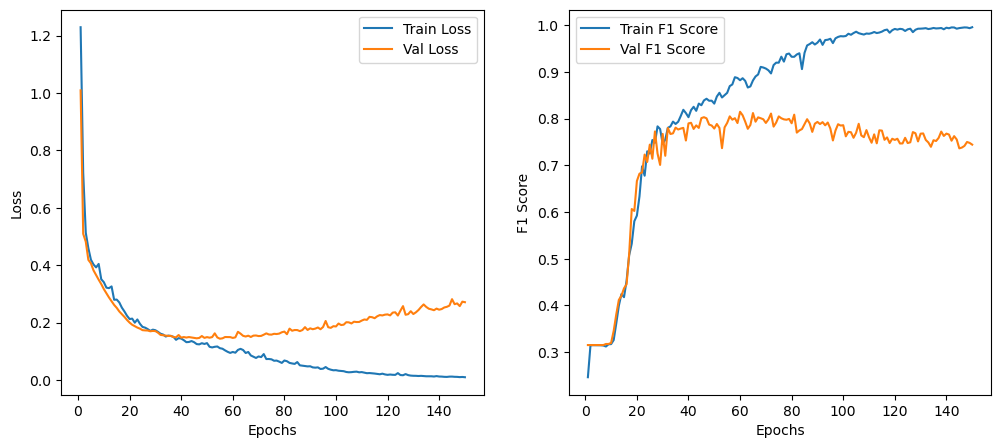

In [12]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()